In [1]:
1+1

2

In [ ]:
include("cosmology.jl")
using PyPlot, ODE, Dierckx, Roots
set_bigfloat_precision(256);

In [36]:
rg(m) = 2.0.*m.*G./C./C
function miso(M0, R, r)
    if r>R
        return M0
    end
    M0.*r./R
end
rgiso(M0, R, r) = rg(miso(M0, R, r))
function ρiso(M0, R, r)
    if r>R
        return 0.0
    end
    M0./R./4.0./pi./r./r
end

function thin_lens(frg, r0, b, endy=0.0, N=100)
    const tgθ = b/r0
    @show const θ=atan(tgθ)
    @show const nθ = θ-2.0*frg(b)/b
    const tgnθ = tan(nθ)
    nx = (endy-b)/tgnθ
    if nθ>0.0
        nx = r0
    end
    
    lx = linspace(0.0,1.0,div(N,2)).^3
    x = [-reverse(lx)*r0; lx*nx]
    y = zeros(length(x))
    for i in 1:length(x)
        y[i] = if x[i]<0.0
            tgθ*(x[i]+r0)
        else
            b+tgnθ*x[i]
        end
    end
    x = [Float64(xx) for xx in x]
    y = [Float64(yy) for yy in y]
    x, y
end

function direct_lens5(frg, r0, b, endy=0.0, N=100)
    tx, ty = thin_lens(frg, r0, b, endy, N)
    ϕf = π-atan(ty[end]/tx[end])
    function f(ϕ, y)
        (u, v) = y
        u_prime = v
        v_prime = 3/2*frg(1/u)*u*u-u
        [u_prime; v_prime]    
    end
    const u0 = 1.0/r0
    const tgθ0 = b/r0
    const du0 = 1.0/(r0*abs(tgθ0))
    start = [u0; du0];
    _t = linspace(0,1,div(N,2)).^0.03
    ϕl=[_t.*π/2; (ϕf-π/2).*_t+π/2]
    
    ϕ, y = ode45(f, start, ϕl, abstol=1.0e-27, reltol=1.0e-45);
    u = map(y -> y[1], y);
    x = [Float64(v) for v in -cos(ϕ)./u]
    y = [Float64(v) for v in sin(ϕ)./u]        
    #spl = Spline1D(x,y, k=5, bc="extrapolate")
    #t = (endy-y[end-100])/(y[end]-y[end-100])
    #xmax = x[end-100]+t*(x[end]-x[end-100]) 
    #lx = linspace(0.0,1.0,div(N,2)).^3
    #x = [-reverse(lx)*r0; lx*xmax]
    #y = evaluate(spl, x)
    x,y
end

function analytic_lens(M0, R, b, r0)
    function u_out(ϕ)
        m0 = G*M0/C/C
        B = 1/r0 - 2m0/b/b
        ϕ0 = (1-3*m0/R)^(-0.5)*acos(b/R)        
        if ϕ<0
            ϕ0 = -ϕ0
        end
        A = (1/R-(1/r0-2m0/b/b)*sin(ϕ0)-3m0/2/b/b*(1-cos(2ϕ0)/3))   /  cos(ϕ0)
        A*cos(ϕ) + B*sin(ϕ) + 3m0/2/b/b*(1-cos(2ϕ)/3)
    end

    N = 1000
    x = zeros(N)
    y = zeros(N)
    ϕl = linspace(-π/2, π/2, N)
    for i in 1:N
        u = u_out(ϕl[i])
        r = 1./u
        x[i] = -r*sin(ϕl[i])
        y[i] = r*cos(ϕl[i])
    end
    x,y
end

analytic_lens (generic function with 1 method)

In [37]:
function mfac(M0, R, rp, N)
    tot = 0.0
    ptot = 0.0
    @inbounds for i in 1:N
        x=rand()*rp+1.0e-2
        y=rand()*rp+1.0e-2
        z=rand()*R+1.0e-2
        r=sqrt(x*x+y*y+z*z)
        r>R && continue
        pr = sqrt(x*x+y*y)
        pr > rp && continue
        ρ=ρiso(M0, R, r)        
        ptot += ρ
        if r <= rp
            tot += ρ
        end
    end
    ptot/tot
end

mfac (generic function with 1 method)

In [52]:
Mmw = big"200.0";
Rmw = big"50.0";
mf = mfac(Float64(Mmw), Float64(Rmw), 30.0, 50000000)

1.2624917412412497

In [53]:
m0 = G*Mmw/C/C;
b = big"30.0";
r0 = b*b/2/m0

4.702012347165559976916881038287886906881032964571503812042279255799791137164303e+06

In [54]:
endy=0.0
dx,dy = direct_lens5(r->rgiso(Mmw, Rmw, r), r0, b, endy, 100000);

const θ = atan(tgθ) = 6.38024696334056881771349905239913707278567491444775949245436616436457082883915e-06
const nθ = θ - (2.0 * frg(b)) / b = -1.276049392772003455804863558711584892195567449655074459083735707604948764663945e-06


In [55]:
endy=0.0
tx,ty = thin_lens(r->rgiso(Mmw*mf, Rmw, r), r0, b, endy, 1000);

const θ = atan(tgθ) = 6.38024696334056881771349905239913707278567491444775949245436616436457082883915e-06
const nθ = θ - (2.0 * frg(b)) / b = -3.285763954747028072535372385630141071052867404858270864883356634141874977687824e-06


In [56]:
endy=0.0
ax,ay = analytic_lens(Mmw, Rmw, b, r0);

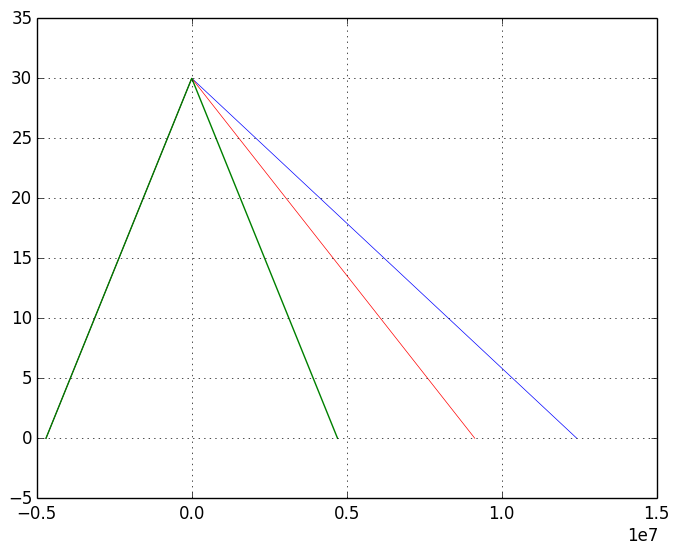

In [57]:
hold(false)
plot(dx, dy, "-b", ms=3.02, lw=0.5)
hold(true)
plot(tx, ty, "-r", ms=0.01, lw=0.5)
plot(ax, ay, "-g", ms=0.01, lw=1.01)
hold(false)
grid(true)
#xlim(-100,100)
#ylim(29.9995,30.0015)

In [19]:
ax[1]

2.0897832653980027e6

In [30]:
dx[2]

-215938.18079213353

In [31]:
dy[2]

26.90008742485427

In [59]:
sin(-pi/2)

-1.0

In [60]:
4*0.1/0.8/0.8-1/0.1

-9.375

In [61]:
0.8*0.8/2/0.1

3.2000000000000006